In [71]:
import matplotlib.pyplot as plt
import datetime
from datetime import  timedelta
from datetime import datetime as dt
import numpy as np
import os
import re
import logging
import pandas as pd
import xarray as xr
import plotly.express as px
from dash import Dash, dcc, html, callback, Input, Output


############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import numpy as np
import importlib
import multiprocessing as mp
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import xarray as xr
import numpy as np

# project_dir = '/Users/demo/Library/CloudStorage/Box-Box/Holmes_Lab_Wiki/PCX_Round2'
# sub_logs = os.path.join(project_dir, 'subject_logs')

# subs = {}
# for sub in os.listdir(sub_logs):
#     if 'sub-' in sub:
#         parts = sub.split('.')
#         sub_id = parts[0]
#         subs[sub_id] = pd.read_excel(os.path.join(sub_logs, sub),sheet_name='JSON_formatted')

import sys
import os
import pandas as pd
import datetime
from datetime import datetime as dt
import plotly.express as px

def extract_survey_date(filename: str):
	"""
	Extracts a survey date from a filename of the form '..._<Month Day, Year>.csv'
	Example: 'survey_results_Sep 06, 2025.csv' → datetime(2025, 9, 6)
	"""
	try:
		# Grab the last part after the last underscore, before the extension
		datestr = filename.split('_')[-1].split('.')[0]
		return dt.strptime(datestr, '%b %d, %Y')
	except Exception:
		return None
	
def get_most_recent_survey(directory, recoded=False):
	# Allowed Excel extensions
	extensions = (".csv", ".xls", ".xlsx")
	filenames = [f for f in os.listdir(directory) if f.endswith(extensions)]
	if recoded==True:
		filenames = [f for f in filenames if 'recoded' in f]
	else:
		filenames = [f for f in filenames if not 'recoded' in f]
	
	# List Excel files with their sizes
	dates = []
	for filename in filenames:

		survey_date = extract_survey_date(filename)
		if survey_date is not None:
			dates.append({'filename': filename, 'date': survey_date})
			

	if len(dates) > 0:
		dates.sort(key=lambda file: file['date'], reverse=True)

		return os.path.join(directory, dates[0]['filename'])
	
	return None



data_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/(Restricted)_PCR/PCX')

# project where survey exports live
surveys_dir = os.path.join(data_dir, 'behavioral')



survey_names = ['clinical_administered_data','clinical_self_report_data',
					 'mri_self_report_data','supplemental_self_report_data']
subsurvey_key = {
	'panss': 'clinical_administered_data',
	'madrs': 'clinical_administered_data',
	'ymrs': 'clinical_administered_data',
	'bprs': 'clinical_administered_data',
	'cssrs': 'clinical_administered_data',

}

surveys={}
recoded_surveys={}
filepath=None
for root, dirs, files in os.walk(surveys_dir):
	for survey in survey_names: 
		if survey in dirs: 
			surveys[survey] = []
			survey_dir = os.path.join(root, survey)
			try:
				filepath = get_most_recent_survey(survey_dir)
				filepath_recoded = get_most_recent_survey(survey_dir, recoded=True)
			except Exception as e:
				print(e)
			if filepath is not None:
				surveys[survey] = pd.read_csv(filepath)
				recoded_surveys[survey]=pd.read_csv(filepath_recoded)



# num phone data: in accel_df, gps_df, power_df
# num mri data: in surveys['mri_self_report_data']
# num clin interview session: in surveys['clinical_administered_data']
#

In [ ]:
app = Dash(__name__)
subject_ids = ['PCR200', 'PCR201']
mindlamp_dir= os.path.expanduser('~/Library/CloudStorage/Box-Box/(Restricted)_PCR/PCX/mindlamp_mri_data')


def return_recent_df(sub: str, sensor: str):
	data_path = os.path.join(mindlamp_dir, 'data', sub, 'phone', 'processed', sensor)

	if not os.path.exists(data_path):
		return None

	all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

	if not all_files:
		return None

	# Extract the ending day in teh filename (filenames are labeled '...day1to105', '...day1to131', etc)
	matches = [f for f in all_files if re.search(r'to\d+', f)]

	if not matches:
		return None

	# Use max() with key to extract the largest final day
	most_recent_file_key = sorted(matches, reverse=False)[0]
	most_recent_file = [f for f in all_files if most_recent_file_key in f]

	return most_recent_file
	
	
	

def update_dfs(sub:str, sensor:str):
	# Set up logging
	logging.basicConfig(
		filename='update_dataframes.log',        # File to write logs to, saved in working directory
		filemode='a',              # 'a' for append, 'w' to overwrite each time
		level=logging.INFO,        # Minimum logging level
		format='%(asctime)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s'
	)

	data_path = os.path.join(mindlamp_dir, 'data', sub, 'phone', 'processed', sensor)

	if os.path.exists(data_path):
		most_recent_file = return_recent_df(sub, sensor)
		if most_recent_file is not None:
			df = pd.read_csv(os.path.join(data_path, most_recent_file))
			df['subject_id'] = sub
			df['sensor'] = sensor

			# Build mapping for renaming to readable names
			rename_map = {
				f"activityScore_hour{str(i).zfill(2)}": f"{i-1}:00"
				for i in range(1, 25)
			}

			# Apply rename
			df = df.rename(columns=rename_map)

			return df
		else:
			logging.warning(f"No recent {sensor} data found for {sub}")
			return None
	else:
		logging.warning(f"No {sensor} data found for {sub}")
		return None





# App layout
app.layout = html.Div([
	dcc.Dropdown(id='subject-id', value='PCR200', options=[{'label': sub, 'value': sub} for sub in subject_ids]),
	dcc.RadioItems(id='sensor', value='power',
		options=['power','accel','gps']),
	dcc.RadioItems(id='days', value='All days',
		options=['All days','Weekdays','Weekends']),
	dcc.Graph(figure={}, id='sensor-graph'),

])

# Add controls to build the interaction
@callback(
	Output(component_id='sensor-graph', component_property='figure'),
	Input(component_id='subject-id', component_property='value'),
	Input(component_id='days', component_property='value'),
	Input(component_id='sensor', component_property='value'),
)

def cb(sub, days, sensor):
	if not sub:
		return None
	
	sub_df = update_dfs(sub, sensor)

	"""Callback to update the figure based on the selected id"""
	if sub is None:
		return None
	if days == 'Weekdays':
		sub_df = sub_df[sub_df['weekday'].astype(str).str.contains('1|2|3|4|5')]
	elif days == 'Weekends':
		sub_df = sub_df[sub_df['weekday'].astype(str).str.contains('6|7')]
	xr_power = xr.DataArray(sub_df.select_dtypes(include=['number']).values, 
						dims=["Days", "Hours of the Day"],
						coords={"Days": sub_df['day'], "Hours of the Day": sub_df.select_dtypes(include=['number']).columns})
	
	fig = px.imshow(xr_power, origin='lower', title=f'Phone Activity (minutes each hour) for {sub}',
					zmin=0,zmax=60,height=400, width=600)
	return fig


if __name__ == "__main__":
	app.run(inline=True)

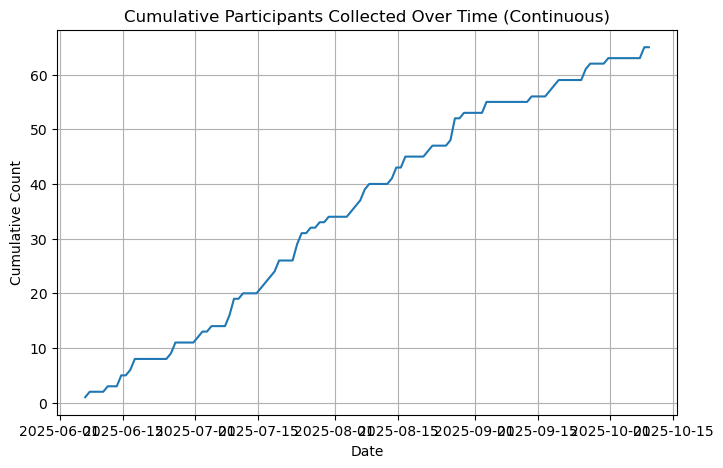

In [ ]:

demographic_df = pd.read_csv('/Users/demo/Library/CloudStorage/Box-Box/(Restricted)_PCR/PCX/demographic_df/demographic_df_Oct 15 2025.csv')

demographic_df["clinical_administered_data"] = pd.to_datetime(demographic_df["clinical_administered_data"], errors="coerce")
demographic_df["mri_self_report_data"] = pd.to_datetime(demographic_df["clinical_administered_data"], errors="coerce")

# Define 2 weeks ago
two_weeks_ago = dt.now() - timedelta(weeks=3)
# Filter
recent_cad = demographic_df[demographic_df['clinical_administered_data'] >= two_weeks_ago]
recent_mri = demographic_df[demographic_df['mri_self_report_data'] >= two_weeks_ago]

recent_demographics = pd.concat([recent_cad, recent_mri])
logging.info(f'Recent demographics before drop_duplicates is length {len(recent_demographics)}')
recent_demographics_clean = recent_demographics.drop_duplicates()
logging.info(f'Recent demographics after drop_duplicates is length {len(recent_demographics)}')

demographic_df_str = (
    demographic_df.groupby("SUBJECT_ID")
    .agg(lambda x: ", ".join(x.dropna().astype(str).unique()))
    .reset_index())


# Make a complete date range
date_range = pd.date_range(demographic_df['clinical_administered_data'].min(), demographic_df['clinical_administered_data'].max())

# Count how many participants per date
counts = demographic_df['clinical_administered_data'].value_counts().sort_index()

# Compute the cumulative sum
cumulative_counts = counts.cumsum()
# Reindex cumulative counts to fill missing dates
cumulative_full = cumulative_counts.reindex(date_range, method='ffill').fillna(0)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_full.index, cumulative_full.values)
plt.title("Cumulative Participants Collected Over Time (Continuous)")
plt.xlabel("Date")
plt.ylabel("Cumulative Count")
plt.grid(True)
plt.show()




In [45]:
actual = cumulative_full.reset_index()
actual.columns = ["Date", "Actual_Total"]
display(actual)

,Date,Actual_Total
0,2025-06-06 15:10:05,1
1,2025-06-07 15:10:05,2
2,2025-06-08 15:10:05,2
3,2025-06-09 15:10:05,2
4,2025-06-10 15:10:05,2
...,...,...
121,2025-10-05 15:10:05,63
122,2025-10-06 15:10:05,63
123,2025-10-07 15:10:05,63
124,2025-10-08 15:10:05,65


In [53]:

## also RMR df is just defined in here 
rmr = pd.DataFrame({
    "Date": [
        "Apr 1 2025", "Aug 1 2025", "Dec 1 2025",
        "Apr 1 2026", "Aug 1 2026", "Dec 1 2026",
        "Apr 1 2027", "Aug 1 2027", "Dec 1 2027",
        "Apr 1 2028"
    ],
    "Quarter": [
        "Q1", "Q2", "Q3", "Q4", "Q5",
        "Q6", "Q7", "Q8", "Q9", "Q10"
    ],
    "Participants per site": [
        13, 14, 13, 14, 13,
        14, 13, 14, 13, 14
    ]
})
# Add cumulative and total columns
rmr["Site Cumulative"] = rmr["Participants per site"].cumsum()
rmr["Total"] = rmr["Site Cumulative"] * 2
rmr["Date"] = pd.to_datetime(rmr["Date"])

# --- daily interpolation of expected cumulative totals ---
date_range = pd.date_range(start=rmr["Date"].min(), end=rmr["Date"].max(), freq="D")
expected_daily = pd.Series(index=date_range, dtype=float)

# set quarterly milestone values
expected_daily.loc[rmr["Date"]] = rmr["Total"].values

# interpolate linearly between them
expected_daily = expected_daily.interpolate(method="linear")

# convert to DataFrame
expected_df = expected_daily.reset_index()
expected_df.columns = ["Date", "Expected_Total"]

# --- Merge (align actual dates with most recent expected milestone) ---
merged = pd.merge_asof(
    actual.sort_values("Date"),
    expected_df[["Date", "Expected_Total"]].sort_values("Date"),
    on="Date",
    direction="backward"
)
merged["Expected_Total"] = merged["Expected_Total"].ffill()

display(merged)

# --- Plot ---
fig = px.line(
    merged,
    x="Date",
    y=["Actual_Total", "Expected_Total"],
    title="Actual vs Expected Cumulative Participants",
    labels={"value": "Cumulative Participants", "variable": "Series"}
)
fig.update_layout(legend_title_text="")
fig.show()



,Date,Actual_Total,Expected_Total
0,2025-06-06 15:10:05,1,41.147541
1,2025-06-07 15:10:05,2,41.377049
2,2025-06-08 15:10:05,2,41.606557
3,2025-06-09 15:10:05,2,41.836066
4,2025-06-10 15:10:05,2,42.065574
...,...,...,...
121,2025-10-05 15:10:05,63,67.852459
122,2025-10-06 15:10:05,63,68.065574
123,2025-10-07 15:10:05,63,68.278689
124,2025-10-08 15:10:05,65,68.491803


In [ ]:
mri = surveys["mri_self_report_data"]
display(mri['StartDate']['Unnamed: 0'])

,Unnamed: 0,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,...,Q2_23,Q2_24,Q2_25,Q2_26,Q2_27,Q2_28,SC0,RecipientEmail.1,RecipientFirstName.1,RecipientLastName.1
0,0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,...,INSTRUCTIONS: These questions ask about some o...,INSTRUCTIONS: These questions ask about some o...,INSTRUCTIONS: These questions ask about some o...,INSTRUCTIONS: These questions ask about some o...,INSTRUCTIONS: These questions ask about some o...,INSTRUCTIONS: These questions ask about some o...,Score,RecipientEmail,RecipientFirstName,RecipientLastName
1,1,"{""ImportId"":""startDate"",""timeZone"":""Z""}","{""ImportId"":""endDate"",""timeZone"":""Z""}","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""Z""}","{""ImportId"":""_recordId""}",...,"{""ImportId"":""QID1718964456_23""}","{""ImportId"":""QID1718964456_24""}","{""ImportId"":""QID1718964456_25""}","{""ImportId"":""QID1718964456_26""}","{""ImportId"":""QID1718964456_27""}","{""ImportId"":""QID1718964456_28""}","{""ImportId"":""SC_eyaRW4CBJg9EFFP""}","{""ImportId"":""RecipientEmail""}","{""ImportId"":""RecipientFirstName""}","{""ImportId"":""RecipientLastName""}"
2,2,2025-06-06 16:21:27,2025-06-06 16:52:04,IP Address,130.219.10.90,100,1836,True,2025-06-06 16:52:05,R_6UjjZxf1hi7IOKl,...,Never True,Never True,Never True,Very Often True,Never True,Prefer not to answer,1030,NaN,NaN,NaN
3,3,2025-06-16 13:34:03,2025-06-16 16:56:19,IP Address,130.219.10.90,100,12135,True,2025-06-16 16:56:19,R_31FUo32kgWdRpYx,...,Often True,Sometimes True,Often True,Often True,Often True,Very Often True,28,NaN,NaN,NaN
4,4,2025-06-16 17:46:45,2025-06-16 20:24:03,IP Address,130.219.10.90,100,9437,True,2025-06-16 20:24:04,R_6eWWDV2b24lWKAx,...,Never True,Never True,Sometimes True,Often True,Sometimes True,Often True,4030,NaN,NaN,NaN
5,5,2025-06-25 13:43:07,2025-06-25 17:25:33,IP Address,130.219.10.90,100,13345,True,2025-06-25 17:25:34,R_7IKoSIzISXvJzWN,...,Never True,Very Often True,Very Often True,Never True,Very Often True,Never True,25,NaN,NaN,NaN
6,6,2025-06-27 16:01:49,2025-06-27 16:28:16,IP Address,130.219.10.90,100,1586,True,2025-06-27 16:28:16,R_6jjGLRBNlARkz8u,...,Never True,Never True,Never True,Very Often True,Never True,Sometimes True,2035,NaN,NaN,NaN
7,7,2025-06-27 16:44:42,2025-06-27 17:42:02,IP Address,130.219.10.90,100,3440,True,2025-06-27 17:42:03,R_5c680as7tfUqBmp,...,Very Often True,Very Often True,Very Often True,Sometimes True,Very Often True,Very Often True,29,NaN,NaN,NaN
8,8,2025-07-08 19:09:58,2025-07-08 20:19:13,IP Address,132.183.13.230,100,4155,True,2025-07-08 20:19:14,R_35AVErO8K1Q2N4t,...,Never True,Never True,Sometimes True,Very Often True,Never True,Often True,35,NaN,NaN,NaN
9,9,2025-07-09 16:39:19,2025-07-09 17:00:03,IP Address,130.219.10.90,100,1244,True,2025-07-09 17:00:04,R_731OwaJrQ7dj4Cj,...,Never True,Never True,Sometimes True,Very Often True,Never True,Sometimes True,1021,NaN,NaN,NaN


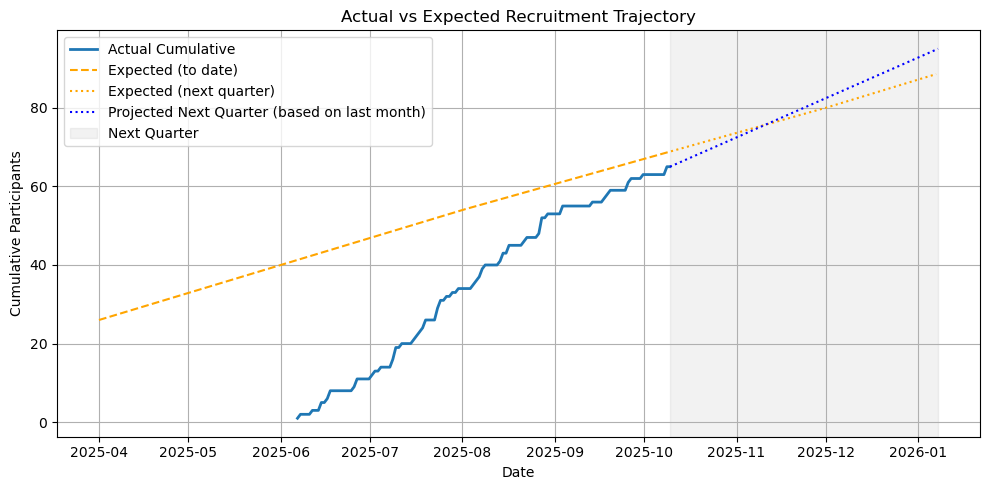

In [ ]:

demographic_df = pd.read_csv('/Users/demo/Library/CloudStorage/Box-Box/(Restricted)_PCR/PCX/demographic_df/demographic_df_Oct 15 2025.csv')


demographic_df["clinical_administered_data"] = pd.to_datetime(demographic_df["clinical_administered_data"], errors="coerce")
demographic_df["mri_self_report_data"] = pd.to_datetime(demographic_df["clinical_administered_data"], errors="coerce")

# Define 2 weeks ago
two_weeks_ago = dt.now() - timedelta(weeks=3)
# Filter
recent_cad = demographic_df[demographic_df['clinical_administered_data'] >= two_weeks_ago]
recent_mri = demographic_df[demographic_df['mri_self_report_data'] >= two_weeks_ago]

recent_demographics = pd.concat([recent_cad, recent_mri])
logging.info(f'Recent demographics before drop_duplicates is length {len(recent_demographics)}')
recent_demographics_clean = recent_demographics.drop_duplicates()
logging.info(f'Recent demographics after drop_duplicates is length {len(recent_demographics)}')

demographic_df_str = (
    demographic_df.groupby("SUBJECT_ID")
    .agg(lambda x: ", ".join(x.dropna().astype(str).unique()))
    .reset_index())


# Make a complete date range
date_range = pd.date_range(demographic_df['clinical_administered_data'].min(), demographic_df['clinical_administered_data'].max())

# Count how many participants per date
counts = demographic_df['clinical_administered_data'].value_counts().sort_index()

# Compute the cumulative sum
cumulative_counts = counts.cumsum()
# Reindex cumulative counts to fill missing dates
cumulative_full = cumulative_counts.reindex(date_range, method='ffill').fillna(0)


## also RMR df is just defined in here 
rmr = pd.DataFrame({
    "Date": [
        "Apr 1 2025", "Aug 1 2025", "Dec 1 2025",
        "Apr 1 2026", "Aug 1 2026", "Dec 1 2026",
        "Apr 1 2027", "Aug 1 2027", "Dec 1 2027",
        "Apr 1 2028"
    ],
    "Quarter": [
        "Q1", "Q2", "Q3", "Q4", "Q5",
        "Q6", "Q7", "Q8", "Q9", "Q10"
    ],
    "Participants per site": [
        13, 14, 13, 14, 13,
        14, 13, 14, 13, 14
    ]
})


# Add cumulative and total columns
rmr["Site Cumulative"] = rmr["Participants per site"].cumsum()
rmr["Total"] = rmr["Site Cumulative"] * 2
rmr["Date"] = pd.to_datetime(rmr["Date"])
rmr = rmr.set_index("Date")

# --- Interpolate expected totals to make it linear over time
expected_linear = rmr["Total"].reindex(
    pd.date_range(rmr.index.min(), rmr.index.max(), freq="D")
).interpolate()

# --- Split into past (up to last actual date) and future
last_actual_date = cumulative_full.index.max()
expected_past = expected_linear.loc[:last_actual_date]
# limit to next quarter
expected_future = expected_linear.loc[last_actual_date : last_actual_date + pd.Timedelta(days=90)]
# --- Calculate recent (last 30 days) growth rate
recent_period = cumulative_full.loc[last_actual_date - pd.Timedelta(days=30): last_actual_date]
if len(recent_period) > 1:
    daily_rate = (recent_period.iloc[-1] - recent_period.iloc[0]) / (recent_period.index[-1] - recent_period.index[0]).days
else:
    daily_rate = 0  # fallback if too few data points

# --- Convert to weekly rate
weekly_rate = daily_rate * 7


# --- Project next quarter (90 days ahead) linearly
projection_dates = pd.date_range(start=last_actual_date, periods=91, freq="D")
projected_values = cumulative_full.iloc[-1] + daily_rate * (projection_dates - projection_dates[0]).days
projected_series = pd.Series(projected_values, index=projection_dates)


# --- Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_full.index, cumulative_full.values, label="Actual Cumulative", linewidth=2)
plt.plot(expected_past.index, expected_past.values, "--", label="Expected (to date)", color="orange")
plt.plot(expected_future.index, expected_future.values, ":", label="Expected (next quarter)", color="orange")
plt.plot(projected_series.index, projected_series.values, ":", label="Projected Next Quarter (based on last month)", color="blue")

# Highlight next quarter
next_q_start = last_actual_date
next_q_end = next_q_start + pd.Timedelta(days=90)
plt.axvspan(next_q_start, next_q_end, color="gray", alpha=0.1, label="Next Quarter")

plt.xlabel("Date")
plt.ylabel("Cumulative Participants")
plt.title("Actual vs Expected Recruitment Trajectory")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



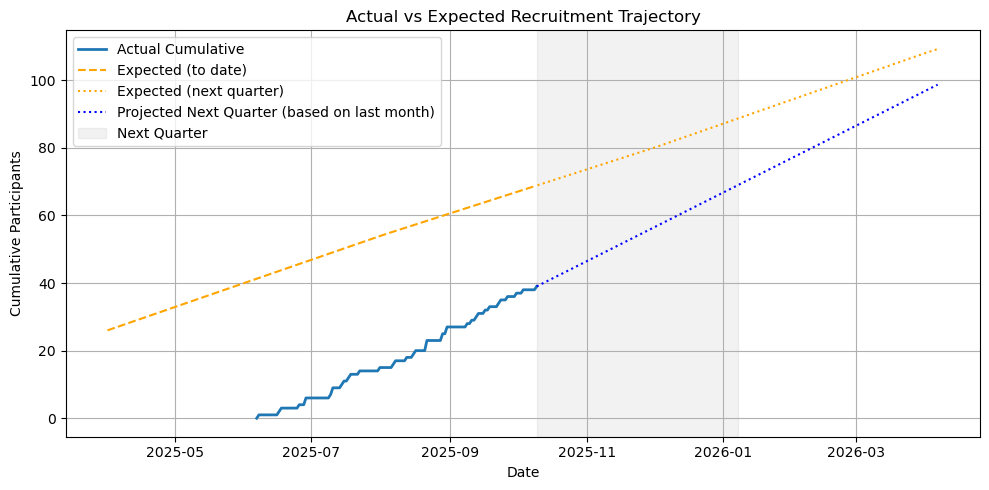

In [77]:

demographic_df = pd.read_csv('/Users/demo/Library/CloudStorage/Box-Box/(Restricted)_PCR/PCX/demographic_df/demographic_df_Oct 15 2025.csv')

demographic_df["mri_self_report_data"] = pd.to_datetime(demographic_df["clinical_administered_data"], errors="coerce")

mri = surveys['mri_self_report_data']
mri["StartDate"] = pd.to_datetime(mri["StartDate"], errors="coerce")


# Define 2 weeks ago
two_weeks_ago = dt.now() - timedelta(weeks=3)
# Filter
recent_mri = mri[mri['StartDate'] >= two_weeks_ago]

recent_demographics = pd.concat([recent_cad, recent_mri])
logging.info(f'Recent demographics before drop_duplicates is length {len(recent_demographics)}')
recent_demographics_clean = recent_demographics.drop_duplicates()
logging.info(f'Recent demographics after drop_duplicates is length {len(recent_demographics)}')

demographic_df_str = (
    demographic_df.groupby("SUBJECT_ID")
    .agg(lambda x: ", ".join(x.dropna().astype(str).unique()))
    .reset_index())


# Make a complete date range
date_range = pd.date_range(demographic_df['mri_self_report_data'].min(), demographic_df['mri_self_report_data'].max())

# Count how many participants per date
mri = surveys['mri_self_report_data']
mri["StartDate"] = pd.to_datetime(mri["StartDate"], errors="coerce")

counts = mri["StartDate"].value_counts().sort_index()
# Compute the cumulative sum
cumulative_counts = counts.cumsum()
# Reindex cumulative counts to fill missing dates
cumulative_full = cumulative_counts.reindex(date_range, method='ffill').fillna(0)


## also RMR df is just defined in here 
rmr = pd.DataFrame({
    "Date": [
        "Apr 1 2025", "Aug 1 2025", "Dec 1 2025",
        "Apr 1 2026", "Aug 1 2026", "Dec 1 2026",
        "Apr 1 2027", "Aug 1 2027", "Dec 1 2027",
        "Apr 1 2028"
    ],
    "Quarter": [
        "Q1", "Q2", "Q3", "Q4", "Q5",
        "Q6", "Q7", "Q8", "Q9", "Q10"
    ],
    "Participants per site": [
        13, 14, 13, 14, 13,
        14, 13, 14, 13, 14
    ]
})
# Add cumulative and total columns
rmr["Site Cumulative"] = rmr["Participants per site"].cumsum()
rmr["Total"] = rmr["Site Cumulative"] * 2
rmr["Date"] = pd.to_datetime(rmr["Date"])
rmr = rmr.set_index("Date")

# --- Interpolate expected totals to make it linear over time
expected_linear = rmr["Total"].reindex(
    pd.date_range(rmr.index.min(), rmr.index.max(), freq="D")
).interpolate()

# --- Split into past (up to last actual date) and future
last_actual_date = cumulative_full.index.max()
expected_past = expected_linear.loc[:last_actual_date]
# limit to next quarter
expected_future = expected_linear.loc[last_actual_date : last_actual_date + pd.Timedelta(days=180)]
# --- Calculate recent (last 30 days) growth rate
recent_period = cumulative_full.loc[last_actual_date - pd.Timedelta(days=90): last_actual_date]
if len(recent_period) > 1:
    daily_rate = (recent_period.iloc[-1] - recent_period.iloc[0]) / (recent_period.index[-1] - recent_period.index[0]).days
else:
    daily_rate = 0  # fallback if too few data points

# --- Convert to weekly rate
weekly_rate = daily_rate * 7


# --- Project next quarter (90 days ahead) linearly
projection_dates = pd.date_range(start=last_actual_date, periods=180, freq="D")
projected_values = cumulative_full.iloc[-1] + daily_rate * (projection_dates - projection_dates[0]).days
projected_series = pd.Series(projected_values, index=projection_dates)


# --- Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_full.index, cumulative_full.values, label="Actual Cumulative", linewidth=2)
plt.plot(expected_past.index, expected_past.values, "--", label="Expected (to date)", color="orange")
plt.plot(expected_future.index, expected_future.values, ":", label="Expected (next quarter)", color="orange")
plt.plot(projected_series.index, projected_series.values, ":", label="Projected Next Quarter (based on last month)", color="blue")

# Highlight next quarter
next_q_start = last_actual_date
next_q_end = next_q_start + pd.Timedelta(days=90)
plt.axvspan(next_q_start, next_q_end, color="gray", alpha=0.1, label="Next Quarter")

plt.xlabel("Date")
plt.ylabel("Cumulative Participants")
plt.title("Actual vs Expected Recruitment Trajectory")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:

## also RMR df is just defined in here 
rmr = pd.DataFrame({
    "Date": [
        "Apr 1 2025", "Aug 1 2025", "Dec 1 2025",
        "Apr 1 2026", "Aug 1 2026", "Dec 1 2026",
        "Apr 1 2027", "Aug 1 2027", "Dec 1 2027",
        "Apr 1 2028"
    ],
    "Quarter": [
        "Q1", "Q2", "Q3", "Q4", "Q5",
        "Q6", "Q7", "Q8", "Q9", "Q10"
    ],
    "Participants per site": [
        13, 14, 13, 14, 13,
        14, 13, 14, 13, 14
    ]
})
# Add cumulative and total columns
rmr["Site Cumulative"] = rmr["Participants per site"].cumsum()
rmr["Total"] = rmr["Site Cumulative"] * 2
rmr["Date"] = pd.to_datetime(rmr["Date"])
rmr = rmr.set_index("Date")

# --- Interpolate expected totals to make it linear over time
expected_linear = rmr["Total"].reindex(
    pd.date_range(rmr.index.min(), rmr.index.max(), freq="D")
).interpolate()
display(expected_linear.values)

array([ 26.        ,  26.2295082 ,  26.45901639, ..., 269.54098361,
       269.7704918 , 270.        ])

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go

# -----------------------------
# Prepare data
# -----------------------------
demographic_df = pd.read_csv('/Users/demo/Library/CloudStorage/Box-Box/(Restricted)_PCR/PCX/demographic_df/demographic_df_Oct 15 2025.csv')
demographic_df["mri_self_report_data"] = pd.to_datetime(demographic_df["clinical_administered_data"], errors="coerce")

mri = demographic_df[["SUBJECT_ID", "mri_self_report_data"]].copy()
mri = mri.dropna(subset=["mri_self_report_data"])

# Full date range
date_range = pd.date_range(mri["mri_self_report_data"].min(), mri["mri_self_report_data"].max())

# Cumulative counts
counts = mri["mri_self_report_data"].value_counts().sort_index()
cumulative_counts = counts.cumsum()
cumulative_full = cumulative_counts.reindex(date_range, method='ffill').fillna(0)

last_actual_date = cumulative_full.index.max()
last_actual_value = cumulative_full.iloc[-1]


## also RMR df is just defined in here 
rmr = pd.DataFrame({
    "Date": [
        "Apr 1 2025", "Aug 1 2025", "Dec 1 2025",
        "Apr 1 2026", "Aug 1 2026", "Dec 1 2026",
        "Apr 1 2027", "Aug 1 2027", "Dec 1 2027",
        "Apr 1 2028"
    ],
    "Quarter": [
        "Q1", "Q2", "Q3", "Q4", "Q5",
        "Q6", "Q7", "Q8", "Q9", "Q10"
    ],
    "Participants per site": [
        13, 14, 13, 14, 13,
        14, 13, 14, 13, 14
    ]
})
# Add cumulative and total columns
rmr["Site Cumulative"] = rmr["Participants per site"].cumsum()
rmr["Total"] = rmr["Site Cumulative"] * 2
rmr["Date"] = pd.to_datetime(rmr["Date"])
rmr = rmr.set_index("Date")

# --- Interpolate expected totals to make it linear over time
rmr_linear = rmr["Total"].reindex(
    pd.date_range(rmr.index.min(), rmr.index.max(), freq="D")
).interpolate()

cutoff = last_actual_date + pd.Timedelta(days=180)
rmr_linear = rmr_linear.loc[:cutoff]

# -----------------------------
# Dash App
# -----------------------------
app = Dash(__name__)

app.layout = html.Div([
    html.H3("Recruitment Trajectory Projection"),
    
    html.Div([
        html.Label("Adjust Weekly Growth Rate (participants/week):"),
        dcc.Slider(
            id='weekly-rate-slider',
            min=0,
            max=20,
            step=0.5,
            value=1,  # initial weekly rate
            marks={i: str(i) for i in range(0, 6, 1)}
        ),
    ], style={'width': '50%', 'padding': '20px'}),

    dcc.Graph(id='recruitment-graph')
])

# -----------------------------
# Callback
# -----------------------------
@app.callback(
    Output('recruitment-graph', 'figure'),
    Input('weekly-rate-slider', 'value')
)
def update_graph(weekly_rate):
    # Convert weekly rate to daily
    daily_rate = weekly_rate / 7

    # Project next 180 days
    projection_dates = pd.date_range(start=last_actual_date + pd.Timedelta(days=1), periods=180)
    projected_values = last_actual_value + daily_rate * np.arange(1, 180)
    
    fig = go.Figure()
    # Actual cumulative
    fig.add_trace(go.Scatter(x=cumulative_full.index, y=cumulative_full.values,
                             mode='lines+markers', name='Actual Cumulative', line=dict(color='blue', width=1,)))
    # Projected
    fig.add_trace(go.Scatter(x=projection_dates, y=projected_values,
                             mode='lines', name='Projected (based on slider)', line=dict(color='blue', width=1, dash='dash')))

    fig.add_trace(go.Scatter(x=rmr_linear.index, y=rmr_linear.values,
                             mode='lines', name='RMR Goal Values', line=dict(color='orange', width=1)))

    # Highlight next quarter
    fig.add_vrect(x0=last_actual_date, x1=last_actual_date + pd.Timedelta(days=180),
                  fillcolor="gray", opacity=0.1, layer="below", line_width=0, annotation_text="Next Quarter")

    fig.update_layout(title=f"Actual vs Projected Recruitment Trajectory", subtitle=f'At Weekly Rate {weekly_rate} subjects/week',
                      xaxis_title="Date", yaxis_title="Cumulative Participants",
                      template="plotly_white", height=500)
    return fig

# -----------------------------
# Run App
# -----------------------------
if __name__ == "__main__":
    app.run(debug=True)